In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

from fastai.vision.all import *
from fastai.text.all import *
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision

import torchtext
from torchtext.data import get_tokenizer   # for tokenization
from collections import Counter     # for tokenizer

import torchvision.transforms as T
import torchvision.models as models

import matplotlib.pyplot as plt
# import matplotlib.image as Image
import PIL
from PIL import Image

# for the bleu scores
from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu

/home/udhay/miniconda3/envs/sub/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=2)

## Data PreProcessing

We have both images and captions in a csv file. Both are easily accessible, one in a csv file and corresponding image using the image id.

In [ ]:
captions_path = "captions.txt"
images_path = "Images/"

**Read the Captions**

Captions are inside a csv file (image id -> Image description in Hindi).

We have 4 types of captions csv files but we will start with simple one (clean 5 sentences).

In [ ]:
import pandas as pd
file_path = "captions.txt"
with open(file_path, "r", encoding="utf-8") as file:
    lines = file.readlines()
data = [line.strip().split("\t") for line in lines]
df = pd.DataFrame(data, columns=["image", "english", "hindi"])

In [ ]:
print(f"No of captions: {len(df)}")
df = df[:1011]
df = df.sample(frac=1).reset_index(drop=True)
df.head()

No of captions: 20343


,image,english,hindi
0,74px-Compass_%28drawing%29.svg.png,The image is a pair of scissors.,छवि कैंची की एक जोड़ी है।
1,101px-Knife_MET_36.25.770_002june2014.jpg,An 18th-century knife with a bone handle and a steel blade.,हड्डी के हैंडल और स्टील के ब्लेड के साथ 18 वीं शताब्दी का चाकू।
2,89px-People_-_Dentist_%289337%29_--_Smart-Servier.png,A cartoon of a male nurse wearing a white uniform and blue gloves.,सफेद वर्दी और नीले दस्ताने पहने एक पुरुष नर्स का कार्टून।
3,118px-Great_Comet_of_1811%2C_Chudniv%2C_p._169_%28reverse_side%29.jpg,Document with handwritten notes.,हस्तलिखित टिप्पणियों के साथ दस्तावेज़।
4,101px-LG_WP-A48PW_Washing_Machine.jpg,The image shows an old and dirty washing machine.,तस्वीर में एक पुरानी और गंदी कपड़े धोने की मशीन दिखाई दे रही है।


**Descriptor mapping**

Now i just want to map each image id to its 5 different descriptions for calculating bleu scores.

In [ ]:
class my_dictionary(dict):

    # __init__ function
    def __init__(self):
        self = dict()

    # Function to add key:value
    def add(self, key, value):
        if key not in self.keys():
            self[key] = [value]
        else:
            self[key].append(value)

descriptors = my_dictionary()

In [ ]:
for i in range(len(df)):
    img_id = df.iloc[i, 0]
    sentence = ("<start> " + df.iloc[i, 2] + " <end>").split()

    descriptors.add(img_id, sentence)

**Check any Image**

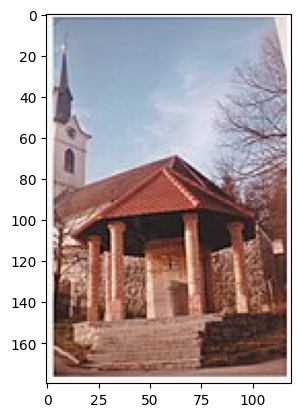

एक टाइल की छत के साथ पत्थर के कुएं का घर।


In [ ]:
# get image path
image_indx = 15
image_path = images_path + df.iloc[image_indx, 0]

# read the image
img = Image.open(image_path)
plt.imshow(img)
plt.show()

# print the captions related to this image
for i in range(image_indx, image_indx+1):
    print(df.iloc[i, 2])

## DATA PROCESSING

We have process the data, so that we can create dataloaders.

Because here we will use fastai libraries, learner (that has many functionalities like no need of doing image encoding on your side).

In [ ]:
# TOKENIZER
tokenizer = get_tokenizer("basic_english")   # works for HINDI also

# TOKEN COUNTER
token_counter = Counter()

**Text Data**

Since, to we have to fed the data inside a dataloder or model.

We have to numericalize the text for this we have create a vocabulary.

This is our Vocabulary class, we created a class because different methods would be available in one container.

This single class has different functionalities like :-
1. Tokenization
2. Numericalization
3. Creating Dictionary

In [ ]:
class textVocab:
    # method to initialize the variables
    def __init__(self):
        # MAIN DICT
        # create dict (int to word) (like token counter)
        self.itos = {0:"<PAD>", 1:"<start>", 2:"<end>", 3:"<UNK>"}

        # create dict (word to int)
        self.stoi = {b:a for a, b in self.itos.items()}

        # initialize word freq threshold
        self.min_freq = 1

        # MAIN COMPONENTS
        # tokenizer
        self.tokenizer = get_tokenizer("basic_english")   # works for HINDI also

        # token counter
        self.token_counter = Counter()

    # method to get size of vocabulary
    def __len__(self):
        return len(self.itos)

    # method to tokenize sentence
    def tokenize(self, text):
        return self.tokenizer(text)

    # method to numericalize sentence
    def numericalize(self, text):

        # tokenize the sentence
        tokens_list = self.tokenize(text)

        ans = []
        # convert words into ints (using stoi)
        for token in tokens_list:
            if token in self.stoi.keys():
                ans.append(self.stoi[token])
            else:
                ans.append(self.stoi["<UNK>"])
        return ans
#         return [ self.stoi[token] if token in self.stoi.keys() else self.stoi["<UNK>"] for token in tokens_list]

    # method to add new sentences to dict
    def build_vocab(self, sentence_list):
        word_count = 4

        # for each sentence
        for sentence in sentence_list:

            # tokenize
            tokens = self.tokenizer(sentence)

            # numericalize
            token_counter.update(tokens)

            # add words to vocab whose freq is >= min freq
            for token in tokens:
                if token_counter[token] >= self.min_freq and token not in self.stoi.keys():
                    self.stoi[token] = word_count
                    self.itos[word_count] = token
                    word_count += 1

**Image Data**

https://pytorch.org/hub/pytorch_vision_inception_v3/

Since Inception v3 is not a linear/straight model hence i have to take the individual layers and pass the image through them to get [1, 2048, 8, 8] size feature vector as output.

shape of the feature vector as input passes through them: -

    torch.Size([1, 3, 299, 299])
    torch.Size([1, 32, 149, 149])
    torch.Size([1, 32, 147, 147])
    torch.Size([1, 64, 147, 147])
    torch.Size([1, 64, 73, 73])
    torch.Size([1, 80, 73, 73])
    torch.Size([1, 192, 71, 71])
    torch.Size([1, 192, 35, 35])
    torch.Size([1, 256, 35, 35])
    torch.Size([1, 288, 35, 35])
    torch.Size([1, 288, 35, 35])
    torch.Size([1, 768, 17, 17])
    torch.Size([1, 768, 17, 17])
    torch.Size([1, 768, 17, 17])
    torch.Size([1, 768, 17, 17])
    torch.Size([1, 768, 17, 17])
    torch.Size([1, 768, 17, 17])
    torch.Size([1, 1280, 8, 8])
    torch.Size([1, 2048, 8, 8])


In [ ]:
inception = models.inception_v3(pretrained=True)

/home/udhay/miniconda3/envs/sub/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/udhay/miniconda3/envs/sub/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
class MyInceptionFeatureExtractor(nn.Module):
    def __init__(self, inception, transform_input=False):
        super(MyInceptionFeatureExtractor, self).__init__()
        self.transform_input = transform_input
        self.Conv2d_1a_3x3 = inception.Conv2d_1a_3x3
        self.Conv2d_2a_3x3 = inception.Conv2d_2a_3x3
        self.Conv2d_2b_3x3 = inception.Conv2d_2b_3x3

        # extra layers has been added since the comment
        self.maxpool1 = inception.maxpool1
        self.Conv2d_3b_1x1 = inception.Conv2d_3b_1x1
        self.Conv2d_4a_3x3 = inception.Conv2d_4a_3x3
        self.maxpool2 = inception.maxpool2

        self.Mixed_5b = inception.Mixed_5b
        self.Mixed_5c = inception.Mixed_5c
        self.Mixed_5d = inception.Mixed_5d
        self.Mixed_6a = inception.Mixed_6a
        self.Mixed_6b = inception.Mixed_6b
        self.Mixed_6c = inception.Mixed_6c
        self.Mixed_6d = inception.Mixed_6d
        self.Mixed_6e = inception.Mixed_6e

        self.AuxLogits = inception.AuxLogits

        self.Mixed_7a = inception.Mixed_7a
        self.Mixed_7b = inception.Mixed_7b
        self.Mixed_7c = inception.Mixed_7c

        # stop where you want, copy paste from the model def

    def forward(self, x):
#         if self.transform_input:
#             x = x.clone()
#             x[0] = x[0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
#             x[1] = x[1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
#             x[2] = x[2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5

        # 299 x 299 x 3
        x = self.Conv2d_1a_3x3(x)
        # 149 x 149 x 32
        x = self.Conv2d_2a_3x3(x)
        # 147 x 147 x 32
        x = self.Conv2d_2b_3x3(x)
        # 147 x 147 x 64
        x = self.maxpool1(x)
        # 73 x 73 x 64
        x = self.Conv2d_3b_1x1(x)
        # 73 x 73 x 80
        x = self.Conv2d_4a_3x3(x)
        # 71 x 71 x 192
        x = self.maxpool2(x)
        # 35 x 35 x 192
        x = self.Mixed_5b(x)
        # 17 x 17 x 768
        x = self.Mixed_5c(x)
        # 17 x 17 x 768
        x = self.Mixed_5d(x)
        # 17 x 17 x 768
        x = self.Mixed_6a(x)
        # 17 x 17 x 768
        x = self.Mixed_6b(x)
        # 17 x 17 x 768
        x = self.Mixed_6c(x)
        # 17 x 17 x 768
        x = self.Mixed_6d(x)
        # 17 x 17 x 768
        x = self.Mixed_6e(x)

        # were not working so i have to remove it
#         x = self.AuxLogits(x)

        # 17 x 17 x 768
        x = self.Mixed_7a(x)
        # 8 x 8 x 1280
        x = self.Mixed_7b(x)
        # 8 x 8 x 2048
        x = self.Mixed_7c(x)

        return x

First, Read the imgage and then apply transform to convert it into a tensor as expected by the model (inception v3).

In [ ]:
# define the transforms
inception_Transform = T.Compose([
    T.Resize(299),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## DATASETS AND DATALOADERS

Here it works like this, We will create a custom dataset and then wrap it inside a dataloaders object.

We will use this dataloaders object for training.

### Custom Dataset

In [ ]:
class customDataset(Dataset):
    def __init__(self, image_dir, captions_file, transform=None, min_freq=5):
        self.image_dir = image_dir
        file_path = "captions.txt"
        with open(file_path, "r", encoding="utf-8") as file:
            lines = file.readlines()
        data = [line.strip().split("\t") for line in lines]
        self.df = pd.DataFrame(data, columns=["image", "english", "hindi"])
        self.transform = transform

        # get image ids and captions
        self.img_ids = self.df["image"]
        self.sentences = self.df["hindi"]

        # initialize vocabulary
        self.vocab = textVocab()

        # create vocabulary (using list of sentences)
        self.vocab.build_vocab(self.sentences.tolist())

    def __len__(self):
        return len(self.df)

    # method to return pair of input and output data
    def __getitem__(self, idx):

        # get the caption and image path
        sentence = self.sentences[idx]
        img_id = self.img_ids[idx]
        img_path = os.path.join(self.image_dir, img_id)

        # open the image
        img = Image.open(img_path).convert("RGB")

        # apply transformation on image(resize)
        if self.transform is not None:
            img = self.transform(img)

        # numericalize the caption
        vec = []

        vec += [self.vocab.stoi["<start>"]]   # tagging
        vec += self.vocab.numericalize(sentence)  # numericalization
        vec += [self.vocab.stoi["<end>"]]     # tagging

        # return text vector and image tensor
#         return img_id, vec
        return img, torch.tensor(vec), img_id

I can try to return the image id also and by creating a dictionary from image id to image descriptions i can get all the 5 descriptions per image.

Just create a transformer to resize all images and converting them to tensor.

In [ ]:
transforms = inception_Transform

In [ ]:
transforms

Compose(
    Resize(size=299, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(299, 299))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

Now, Create a dataset object using our custom dataset class.

Later we will use this dataset object to create pytorch dataloderes object (this is the way).

In [ ]:
# Create custom dataset object
dataset = customDataset(
    image_dir = images_path,
    captions_file = captions_path,
    transform = transforms
)

In [ ]:
with open('vocab.pkl', 'wb') as file:

    # A new file will be created
    pickle.dump(dataset.vocab, file)

Till now we have used torch library only and created custome vocabulary class + custom dataset class.

**Divide dataset indices into 2 parts**

- Training
- Testing

In [ ]:
validation_split = 0.01
shuffle_dataset = False
random_seed= 42

In [ ]:
dataset_size = len(dataset)
indices = list(range(dataset_size))

# find the split point
split = int(np.floor(validation_split * dataset_size))

# get the indices
train_indices, val_indices = indices[split:], indices[:split]

# shuffle the dataset
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

**Check our dataset**

In [ ]:
# create utility function to print images
def show_image(img, title=None):

    # unnormalize
    img[0] *= 0.229
    img[1] *= 0.224
    img[2] *= 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406

    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)

    plt.pause(0.001)    # wait for plots

Continuously 5 indices contaisn the same image with 5 different descriptions.

We just want all these 5 descriptions during calculation of bleu score.

180px-Gajillion_Islands_Planet.png


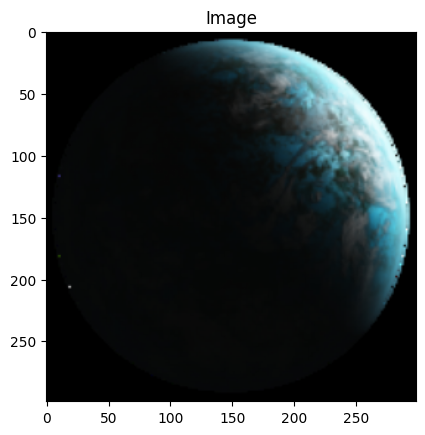

caption:  ['<start>', 'एक', 'संभावित', 'महासागर', 'ग्रह', 'का', 'एक', 'कलाकार', 'प्रतिपादन।', '<end>']


In [ ]:
# get an item from dataset
img, vec, img_id = dataset[8083]
print(img_id)
show_image(img, "Image")

# need to convert returned vector into sentence
caption = [dataset.vocab.itos[token] for token in vec.tolist()]
print("caption: ", caption)

Using just torch and torchvision, we could create implement code till dataset.

### DataLoaders

**Padding function**

Hmm, now i understood this padding sequence method, Pads the vectors to the size of the largest vector in the batch.

We can try different batches it just pads to the largest size vector.

So that every tensor in stack (or batch) have same size.

In [ ]:
class Collate_fn:
    def __init__(self, pad_value, batch_first=False):
        self.pad_value = pad_value       # initialize padding value
        self.batch_first = batch_first    # col or row wise representation

    # this method is called for each batch in dataloader
    def __call__(self, batch):
        # get all inputs images
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)    # single tensor

        # get all captions
        captions = [item[1] for item in batch]

        # do padding on all text vectors   # single tensor
        captions = pad_sequence(captions, batch_first = self.batch_first, padding_value = self.pad_value)

        # get all image ids
        img_ids = [item[2] for item in batch]

        return imgs, captions, img_ids

**Create Dataloader**

We will wrap our custom dataset inside the pytorch dataloaders object and also give it a padding function (will be applied on batches).

Dataloader object helps in model training:-
- they divide the dataset into 2 parts traning and validation set [NO, WE HAVE TO CRETAE THEM SEPERATELY]
- gives batches of input and output data to the model

In [ ]:
# define batch size
batch_size = 64

# initialize value to represent padding
pad_value = dataset.vocab.stoi["<PAD>"]

In [ ]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [ ]:
dls = torch.utils.data.DataLoader(dataset,
                                           batch_size=batch_size, shuffle=False,
                                           collate_fn = Collate_fn(pad_value=pad_value, batch_first = True),
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, shuffle=False,
                                                batch_size=batch_size,
                                                collate_fn = Collate_fn(pad_value=pad_value, batch_first = True),
                                                sampler=valid_sampler)

In [ ]:
# # create dataloader object
# dls = DataLoader(
#         dataset = dataset,
#         batch_size = batch_size,
#         shuffle = True,       # without it gives images in row
#         collate_fn = Collate_fn(pad_value=pad_value, batch_first = True)
# )

**Check Dataloader**

Now check if we are getting the correct items inside the batch.

I THINK THE CAPTIONS SHOULD BE CONTINOUS.

दो आदमी एक नाव को ज्वालामुखी विस्फोट की ओर ले जाते हैं।


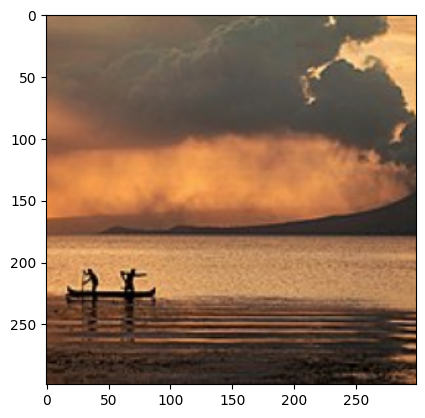

In [ ]:
# dataloader iterator
dlsItr = iter(dls)

# get a batch
batch = next(dlsItr)

# get input and output values
imgs, captions, img_ids = batch

# show all items in it
for i in range(batch_size):
    img, caption = imgs[i], captions[i]

    # convert text vector into sentence
    sentence = [dataset.vocab.itos[token] for token in caption.tolist()]

    # get index of end token
    end_indx = sentence.index('<end>')

    # get from start to end and join
    sentence = sentence[1:end_indx]
    sentence = ' '.join(sentence)

    # also print image
    print(sentence)
    show_image(img)
    plt.show()

    break

## Model Implementation

### Encoder Model

This model is used to encode the images by applying a Pretrained CNN model to extract features.

Here, we can use pre-trained VGG16, InceptionV3 and Resnet50 CNN model. But we will go with inceptionV3 (all have similar results).

https://colab.research.google.com/drive/1RP-XrrNEirNPfA3WluCrbsOJqlVKxbF1#scrollTo=izbiAvYrnqpq

Check which layers we are getting

**For resnet50**: -

Final layers (normally): -

    (2): Bottleneck(
      (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
    (fc): Linear(in_features=2048, out_features=1000, bias=True)
  
  
Final layers (after removing last 2 layers): -

    (2): Bottleneck(
      (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    )
    )
    
**For inception**

Normally : -

    (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
    (dropout): Dropout(p=0.5, inplace=False)
    (fc): Linear(in_features=2048, out_features=1000, bias=True)
  
After removing 3 layers:-

    (branch_pool): BasicConv2d(
    (conv): Conv2d(2048, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    )
    )

Note - removing last 3 layers of model does not works with inception v3. should find some other way to extract features matrix.

In [ ]:
inception = models.inception_v3(pretrained=True)

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.my_inception = MyInceptionFeatureExtractor(inception)
        # initialize the pretrained model (Tested by Balwant)
#         inception = models.inception_v3(pretrained=True)
#         inception.eval()

#         # set the parameteres
#         for para in inception.parameters():
#             para.requires_grad_(False)

#         modules = list(inception.children())[:-3]
#         self.inception = nn.Sequential(*modules)

    def forward(self, images):
#         print(images.shape) = [bs, 3, 299, 299]

        # get the feature maps
        features = self.my_inception(images)
#         print(features.shape) = [bs, 2048, 8, 8]

        features = features.permute(0, 2, 3, 1)
#         print(features.shape) = [bs, 8, 8, 2048]

        features = features.view(features.size(0), -1, features.size(-1))
#         print(features.shape) = [2, 64, 2048]

        return features

## Attention Model

- encoder_dim: feature size of encoded images
- decoder_dim: size of decoder's RNN
- attention_dim: size of the attention network

**Attention model** it is a simple model with 3 linear layers.

We transform the image feature tensor into a attention score(alpha-averaged hence deterministic or soft attention). and usign this alpha we get attention weights tensor.

In [ ]:
class Attention(nn.Module):

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()

        # initialize the shapes
        self.attention_dim = attention_dim

        # create linear layer's to transform following
        # (input shape, output shape)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # decoder's output
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # encoded image
        self.full_att = nn.Linear(attention_dim, 1)  # attention's output

    # input - features of image and hidden state value
    def forward(self, features, hidden_states):
        # pass the tensor's through linear layers
        att1 = self.encoder_att(features)
        att2 = self.decoder_att(hidden_states)

#         print(att1.shape, att2.shape)   # torch.Size([32, 64, att_dim]) torch.Size([32, att_dim])

        # combine both attentions
        combined_states = torch.tanh(att1 + att2.unsqueeze(1))

#         print(combined_states.shape)      # torch.Size([32, 64, att_dim])

        # pass combined state through last linear layer
        attention_scores = self.full_att(combined_states)

#         print(attention_scores.shape)     # torch.Size([bs, 64, 1])
        attention_scores = attention_scores.squeeze(2)
#         print(attention_scores.shape)   # torch.Size([32, 64])


        # calculate alpha
        alpha = F.softmax(attention_scores, dim=1)

        # get attention weights
        weighted_encoding = features * alpha.unsqueeze(2)   # torch.Size([bs, 64, 1])
        weighted_encoding = weighted_encoding.sum(dim=1)    # sum all weights at dim 1

        # return alpha and attention weights (both are tensors)
        return alpha, weighted_encoding


## Decoder Model

- attention_dim: size of attention network
- embed_dim: embedding size
- decoder_dim: size of decoder's RNN
- vocab_size: size of vocabulary
- encoder_dim: feature size of encoded images
- dropout: dropout

In [ ]:
class Decoder(nn.Module):
    def __init__(self, embed_sz, vocab_sz, att_dim, enc_dim, dec_dim, drop_prob=0.3):
        super().__init__()

        # initialize the model parameters
        self.vocab_sz = vocab_sz
        self.att_dim = att_dim
        self.dec_dim = dec_dim

        # initialize embedding model and attention model
        self.embedding = nn.Embedding(vocab_sz, embed_sz)
        self.attention = Attention(enc_dim, dec_dim, att_dim)

        # create the hidden and cell state
        self.init_h = nn.Linear(enc_dim, dec_dim)
        self.init_c = nn.Linear(enc_dim, dec_dim)

        # create lstm cell
        self.lstm_cell = nn.LSTMCell(embed_sz + enc_dim, dec_dim, bias=True)

        # create other nn layers
        self.f_beta = nn.Linear(dec_dim, enc_dim)
        self.fcn = nn.Linear(dec_dim, vocab_sz)
        self.drop = nn.Dropout(drop_prob)

    def forward(self, features, captions):

        # vectorize the captions(tokenized):
        embeds = self.embedding(captions)

        # initialize hidden and cell state
        h, c = self.init_hidden_state(features)

        # get the captions length in current batch
        cap_len = len(captions[0]) - 1

        # get batch size and features size
        batch_sz = captions.size(0)
        num_features = features.size(1)

        # create tensor of zeros for predictions and alpha
        preds = torch.zeros(batch_sz, cap_len, self.vocab_sz).to(device)
        alphas = torch.zeros(batch_sz, cap_len, num_features).to(device)

        for i in range(cap_len):
            # get alpha and attention weights
            alpha, att_weights = self.attention(features, h)

            # create lstm input
            lstm_input = torch.cat((embeds[:,i], att_weights), dim=1)

            # pass through lstm cell
            h, c = self.lstm_cell(lstm_input, (h, c))

            # pass through linear layer
            output = self.fcn(self.drop(h))

            # store the output and alpha
            preds[:, i] = output
            alphas[:, i] = alpha

        return preds, alphas

    # create method to generate captions
    def generate_caption(self, features, max_len=20, vocab=None):
        batch_sz = features.size(0)

        # hidden and cell state
        h, c = self.init_hidden_state(features)

        alphas = []
        captions = [vocab.stoi['<start>']]

        # starting input
        word = torch.tensor(vocab.stoi['<start>']).view(1, -1).to(device)
        embeds = self.embedding(word)

        # get next 20 words
        for i in range(max_len):
            alpha, weighted_encoding = self.attention(features, h)

            # store alpha score
            alphas.append(alpha.cpu().detach().numpy())

            # update hidden and cell state
            lstm_input = torch.cat((embeds[:, 0], weighted_encoding), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))

            # pass through layers
            output = self.fcn(self.drop(h))
            output = output.view(batch_sz, -1)

            # select the best word
            pred_word_idx = output.argmax(dim=1)

            # save the word
            captions.append(pred_word_idx.item())

            # stop when end of sentence
            if vocab.itos[pred_word_idx.item()] == '<end>':
                break

            # next input
            embeds = self.embedding(pred_word_idx.unsqueeze(0))

        # return sentence
        return [vocab.itos[idx] for idx in captions], alphas  # if idx != 0 and idx != 1 and idx != 2

    # method to get hidden and cell state value
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)

        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)

        # return hidden and cell state
        return h, c

## Encoder - decoder model

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self, embed_sz, vocab_sz, att_dim, enc_dim, dec_dim, drop_prob=0.3):
        super().__init__()

        # crete the encoder and decoder models
        self.encoder = Encoder()
        self.decoder = Decoder(
            embed_sz = embed_sz,
            vocab_sz = vocab_sz,
            att_dim = att_dim,
            enc_dim = enc_dim,
            dec_dim = dec_dim
        )

    def forward(self, images, captions):
        # extract image features
        features = self.encoder(images)

        # generate captions
        outputs = self.decoder(features, captions)

        # return predicted caption, attention alphas
        return outputs

## Set the Hyperameters

In [ ]:
embed_sz = 300
vocab_sz = len(dataset.vocab)
att_dim = 256
enc_dim = 2048
dec_dim = 512
learning_rate = 3e-4

## Model

In [ ]:
# initialize model
model = EncoderDecoder(
    embed_sz = 300,
    vocab_sz = len(dataset.vocab),
    att_dim = 128,
    enc_dim = 2048,
    dec_dim = 256
).to(device)

In [ ]:
# create criterion and optimizer for weights
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [ ]:
# function to save model
def save_model(model, num_epochs):
    model_state = {
        'num_epochs' : num_epochs,
        'embed_sz' : embed_sz,
        'vocab_sz' : len(dataset.vocab),
        'enc_dim' : enc_dim,
        'dec_dim' : dec_dim,
        'state_dict' : model.state_dict()
    }

    torch.save(model_state, 'Hindi_1k.pth')

Create the training loops.

In [ ]:
epochs = 12
print_each = 100

In [ ]:
model.train()
for epoch in range(1, epochs+1):
    for idx, (img, captions, img_ids) in enumerate(iter(dls)):

        # store the device (same-same)
        img, captions = img.to(device), captions.to(device)

        # make gradients zero
        optimizer.zero_grad()

        # pass through encoder-decoder model
        pred_caps, attentions = model(img, captions)

        # calculate batch loss
        targets = captions[:, 1:]

        loss = criterion(pred_caps.view(-1, vocab_sz), targets.reshape(-1))

        # backward pass
        loss.backward()    # update the NN weights

        # update the weights in optimizer
        optimizer.step()

        # if it is batch to print
        if (idx + 1) % print_each == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch, loss.item()))

            # generate the captions for a whole batch
            model.eval()
            with torch.no_grad():
                # dls or validation_loader
                itr = iter(validation_loader)
                img, _, _ = next(itr)

                # extract features
                features = model.encoder(img[0:1].to(device))

                # get predictions
                pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)

                # make it printable
                caption = ' '.join(pred_caps)
                print(caption)
                #show_image(img[0])

            # tell now will train
            model.train()

    # save latest model
    save_model(model, epoch)

/home/udhay/miniconda3/envs/sub/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 1 loss: 6.04643
<start> एक एक एक के एक के एक <end>


## Model Testing

**MAKE PREDICTIONS**

We have downloaded the model from previous saved notebooks and will use those to predict and evaluating.

https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html

PATH = 'Unclean5Sentences.pth'

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['state_dict'])

# generate the captions for a whole batch
model.eval()
with torch.no_grad():
    # dls or validation_loader
    itr = iter(validation_loader)
    img, captions, img_ids = next(itr)
    
    caption = captions[0:1][0].tolist()
    s = [dataset.vocab.itos[idx] for idx in caption if idx != 0] # if idx != 0 and idx != 1 and idx != 2
    print("Original:", ' '.join(s))
    
    # extract features
    print(img[0:1].shape)
    features = model.encoder(img[0:1].to(device))

    # get predictions
    pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)

    # make it printable
    caption = ' '.join(pred_caps)
    print("Predicted:", caption)
    show_image(img[0])

**BLEU Score Prediction**

In [ ]:
def evaluateModel(mode, dls):
    model.eval()
    y, yhat = list(), list()

    # iterate all batches
    for idxx, (img, captions, img_ids) in enumerate(iter(dls)):
        print(idxx)
        with torch.no_grad():

            # iterate each record in batch
            for i in range(batch_size):

                # if empty record
                if len(captions[i:i+1]) == 0:
                    break

                # caption = captions[0:1][0].tolist()
                caption = captions[i:i+1][0].tolist()
                s = [dataset.vocab.itos[idx] for idx in caption if idx != 0] #  and idx != 1 and idx != 2

                y.append(descriptors[img_ids[i]])

                # extract features
                features = model.encoder(img[i:i+1].to(device))

                # get predictions
                pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)

                yhat.append(pred_caps)
                # make it printable
                caption = ' '.join(pred_caps)
#                 print("Predicted ", caption)
#                 show_image(img[i])

    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(y, yhat, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(y, yhat, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(y, yhat, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(y, yhat, weights=(0.25, 0.25, 0.25, 0.25)))

Since it is not increasing. Look at the previous semester implementation and follow those hyperparameters.

Last time we got 10 bleu score hence this time this should definitely increase. (maybe last time the test cases were mixed with training cases, Not sure).

In [ ]:
evaluateModel(model, validation_loader)

import torch
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torchtext.data.utils import get_tokenizer

def generate_caption(model, image_path, vocab, max_len=20):
    # Load and preprocess the image
    preprocess = Compose([
        Resize(299),  # Resize to match the model's input size
        CenterCrop(299),
        ToTensor(),   # Convert to tensor
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    image = Image.open(image_path)
    image = preprocess(image).unsqueeze(0)  # Add batch dimension

    # Pass the image through the encoder to extract features
    features = model.encoder(image.to(device))

    # Generate caption using the decoder
    pred_caps, _ = model.decoder.generate_caption(features, max_len=max_len, vocab=vocab)

    # Post-process the generated caption
    caption = ' '.join(pred_caps).replace('<start>', '').replace('<end>', '').strip()
    
    return caption

# Example usage:
image_path = "dog.jpg"
caption = generate_caption(model, image_path, dataset.vocab)
print("Generated Caption:", caption)
